# Prior distributions in the proteomics data set analysis
This notebook describes the prior distributions used in the proteomics data analysis.

In [1]:
require(lgpr)
require(repr)
require(ggplot2)
require(rstan)
require(invgamma)

dataDir <-  "../data/proteomics/"  # Set path to data here
i_prot  <- 450                     # Set protein idx (1-1538) here

readLiuData <- function(dataDir, protein){
  fn_X   <- paste(dataDir,"/liu_preproc_X.csv",sep="")
  fn_Y   <- paste(dataDir,"/liu_preproc_Y.csv",sep="")
  X_data <- read.csv(fn_X, header=TRUE, sep=",")
  X_data <- X_data[,1:5]
  Y_data <- read.csv(fn_Y, header=TRUE, sep=",")
  names  <- colnames(Y_data)
  if(!is.character(protein)){
    pname <- names[protein]
  }else{
    pname <- protein
  }
  
  cat("Read data for protein '", pname, "'. \n", sep = "")
  y      <- Y_data[[pname]]
  notnan <- which(!is.nan(y))
  n_nan  <- length(which(is.nan(y)))
  data   <- data.frame(cbind(X_data, y))
  data   <- data[notnan, ]
  cat("Removed ", n_nan , " rows with NaN value for the response variable.\n", sep = "")
  return(data)
}


FONT_SIZE <- 16
options(repr.plot.width=5, repr.plot.height=3)
data <- readLiuData(dataDir, i_prot)

Loading required package: lgpr
Hello, this is lgpr (version 0.30.2).
Loading required package: repr
Loading required package: ggplot2
Loading required package: rstan
Loading required package: StanHeaders
rstan (Version 2.19.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
Loading required package: invgamma


Read data for protein 'O94769'. 
Removed 9 rows with NaN value for the response variable.


## 1. Sampling from the prior
We can sample from the prior by setting `likelihood="none"`. We also want to set `skip_postproc=TRUE` to avoid computing generated quantities.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.
Warning message:
“Removed 1 rows containing missing values (geom_path).”

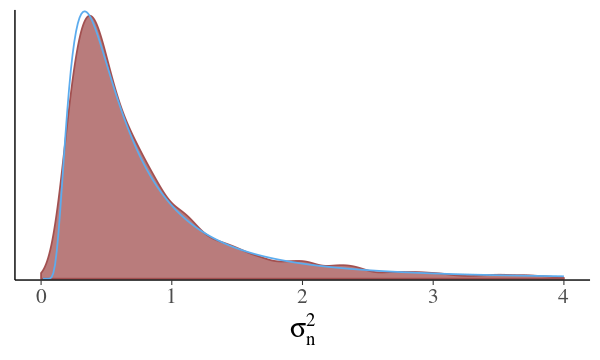

In [2]:
fit   <- lgp(formula      = y ~ id + age + diseaseAge + sex + group,
            data          = data,
            prior         = prior_default(),
            offset_vars   = "group",
            equal_effect  = TRUE,
            likelihood    = "none",
            skip_postproc = TRUE,
            verbose       = FALSE,
            chains        = 4, 
            iter          = 2000,
            refresh       = 0)

fun <- function(x){ x^2 }
plt <- plot_samples(fit, pars = c("sigma_n[1]"), type = "dens", transformations = fun) 
plt <- plt + theme(text=element_text(size=FONT_SIZE)) + xlim(0,4)

# Compare kernel density estimate of samples of sigma_n^2 to inverse-Gamma(2,1)
T  <- 300
t  <- seq(0, 4, length.out = T)
p  <- dinvgamma(t, shape = 2, rate = 1)
df <- data.frame(t, p)
plt <- plt + geom_line(data = df, aes(x=t,y=p), color = 'steelblue2') + xlab(expression(sigma[n]^2))
plt